In [1]:
import numpy as np

This notebook deals with scraping supermarket and mall data from singpore and relating that to the MRT network. Use of **KDTrees and geometrical data** to help calc dist

# Supermarket Data

Data is taken from data.gov

In [2]:
import pandas as pd
import requests

df = pd.read_csv("list-of-supermarket-licences.csv")
df.head()

,licence_num,licensee_name,building_name,block_house_num,level_num,unit_num,street_name,postal_code
0,S02185J000,COLD STORAGE SINGAPORE (1983) PTE LTD,na,982,1,1,BUANGKOK CRESCENT,530982
1,S97166P000,COLD STORAGE SINGAPORE (1983) PTE LTD,HOUGANG GREEN SHOPPING MALL,21,1,52,HOUGANG STREET 51,538719
2,CE15B61K000,U STARS SUPERMARKET PTE. LTD.,na,330,1,1,ANCHORVALE STREET,540330
3,S02029J000,NTUC Fairprice Co-operative Ltd,HOUGANG POINT,1,2,1,HOUGANG STREET 91,538692
4,CE04561V000,SHENG SIONG SUPERMARKET PTE LTD,na,19,1,42401,SERANGOON NORTH AVENUE 5,554913


### Fetch Data from OneMap

In [3]:
def getcoordinates(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']
    else:
        pass

In [4]:
df['Address'] = df['postal_code']
addresslist = list(df['Address'])

In [5]:
coordinateslist= []
count = 0
failed_count = 0
for address in addresslist:
    try:
        if len(getcoordinates(address))>0:
            count = count + 1
            coordinateslist.append(getcoordinates(address))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(addresslist),'addresses')
        coordinateslist.append(None)
print('Total Number of Addresses With No Coordinates: ',failed_count)

Failed to extract 11 out of 478 addresses
Failed to extract 95 out of 478 addresses
Failed to extract 119 out of 478 addresses
Failed to extract 138 out of 478 addresses
Failed to extract 186 out of 478 addresses
Failed to extract 239 out of 478 addresses
Failed to extract 242 out of 478 addresses
Failed to extract 296 out of 478 addresses
Failed to extract 297 out of 478 addresses
Failed to extract 340 out of 478 addresses
Failed to extract 348 out of 478 addresses
Failed to extract 366 out of 478 addresses
Failed to extract 394 out of 478 addresses
Failed to extract 404 out of 478 addresses
Failed to extract 447 out of 478 addresses
Failed to extract 452 out of 478 addresses
Failed to extract 467 out of 478 addresses
Total Number of Addresses With No Coordinates:  17


In [6]:
CL = [(None,None) if v is None else v for v in coordinateslist]

In [7]:
latlng = np.array(CL, dtype=object, ndmin=2)

In [8]:
df['lat']= latlng[:,0]
df['lng']=latlng[:,1]

In [9]:
df.head()

,licence_num,licensee_name,building_name,block_house_num,level_num,unit_num,street_name,postal_code,Address,lat,lng
0,S02185J000,COLD STORAGE SINGAPORE (1983) PTE LTD,na,982,1,1,BUANGKOK CRESCENT,530982,530982,1.3808503546459,103.879309094304
1,S97166P000,COLD STORAGE SINGAPORE (1983) PTE LTD,HOUGANG GREEN SHOPPING MALL,21,1,52,HOUGANG STREET 51,538719,538719,1.37931783499145,103.88784708944
2,CE15B61K000,U STARS SUPERMARKET PTE. LTD.,na,330,1,1,ANCHORVALE STREET,540330,540330,1.3968497990014,103.889246755784
3,S02029J000,NTUC Fairprice Co-operative Ltd,HOUGANG POINT,1,2,1,HOUGANG STREET 91,538692,538692,1.37561464129476,103.879483534695
4,CE04561V000,SHENG SIONG SUPERMARKET PTE LTD,na,19,1,42401,SERANGOON NORTH AVENUE 5,554913,554913,1.37563500157221,103.871996419103


In [10]:
print(f"No of rows dropped: {df[df['lat'].isna()].shape[0]}")
print(f"Total number of rows: {df.shape[0]}")
print(f"Percent of data lost {df[df['lat'].isna()].shape[0]*100/df.shape[0]}")
df.dropna(subset=['lat','lng'], inplace = True)

No of rows dropped: 17
Total number of rows: 478
Percent of data lost 3.5564853556485354


In [11]:
import pkg_resources
import scipy
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

## Bring in data from Clusters

In [89]:
data = pd.read_csv("dataCombined_3Clusters.csv")
data.describe()

,Unnamed: 0,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,totalTapIn,totalTapOut,Cluster,postal,x,y,lat,long,bus count,pop
count,151.000000,27.000000,0.0,32.000000,33.00000,17.000000,2.000000,2.000000,36.000000,1.0,27.000000,1.0,2.000000,1.0,127.000000,127.000000,127.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,149.00000
mean,2132.920530,14.814815,NaN,16.500000,17.00000,9.941176,3.500000,1.500000,19.416667,0.0,16.074074,0.0,1.500000,0.0,253448.606299,253141.876640,1.055118,390175.781457,28899.919398,34586.936311,1.329066,103.841405,17.152318,16707.38255
std,1618.212353,8.208987,NaN,9.380832,9.66954,5.153525,3.535534,0.707107,10.672729,NaN,9.675210,NaN,0.707107,NaN,209288.243496,216656.428593,0.928449,231022.490961,7351.882066,4682.218114,0.042344,0.066061,13.511352,22976.72625
min,0.000000,1.000000,NaN,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,21891.000000,22013.000000,0.000000,18925.000000,6150.862788,27545.853430,1.265389,103.636991,0.000000,0.00000
25%,540.000000,8.500000,NaN,8.750000,9.00000,6.000000,2.250000,1.250000,10.750000,0.0,7.500000,0.0,1.250000,0.0,82850.833335,77788.875000,0.000000,189033.000000,25134.411655,31322.069460,1.299540,103.807570,7.000000,720.00000
50%,2040.000000,15.000000,NaN,16.500000,17.00000,10.000000,3.500000,1.500000,19.500000,0.0,16.000000,0.0,1.500000,0.0,186464.750000,179801.500000,1.000000,398006.000000,29473.124940,33698.726310,1.321027,103.846555,14.000000,9090.00000
75%,3540.000000,21.500000,NaN,24.250000,25.00000,14.000000,4.750000,1.750000,28.250000,0.0,24.500000,0.0,1.750000,0.0,397368.250000,370259.875000,2.000000,571946.500000,33345.748700,36582.363990,1.347111,103.881353,23.000000,28020.00000
max,5038.000000,28.000000,NaN,32.000000,33.00000,18.000000,6.000000,2.000000,37.000000,0.0,31.000000,0.0,2.000000,0.0,985138.250000,998749.500000,2.000000,828868.000000,45201.320390,47854.199840,1.449051,103.987884,65.000000,130980.00000


In [90]:
from scipy.interpolate import griddata
from scipy.interpolate import interp2d, RectBivariateSpline, RegularGridInterpolator

In [91]:
import geopandas as gpd
market_gdf = gpd.GeoDataFrame(df, 
            geometry=gpd.points_from_xy(df.lat, df.lng))
mrt_gdf = gpd.GeoDataFrame(data,
                          geometry = gpd.points_from_xy(data.lat, data.long))

# Dist to Supermarket nearest market with KD tree

In [545]:
# from scipy.spatial import cKDTree

# def ckdnearest(gdA, gdB):

#     nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
#     nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
#     btree = cKDTree(nB)
#     dist, idx = btree.query(nA, k=1)
#     gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
#     gdf = pd.concat(
#         [
#             gdA.reset_index(drop=True),
#             gdB_nearest,
#             pd.Series(dist, name='dist')
#         ], 
#         axis=1)

#     return gdf

# combinedData = ckdnearest(mrt_gdf, market_gdf)

# Number of supermarkets to MRT within radius

In [92]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

numberOfKM = 3

def toFloat(n):
    return float(n);

b = list(map(toFloat, df.lat))
c = list(map(toFloat, df.lng))
circleMarket = gpd.GeoDataFrame([
    {'geometry': Point(x, y).buffer(0.008*numberOfKM)}
    for x, y in zip(b,c)])

d = list(map(toFloat, data.lat))
e = list(map(toFloat, data.long))
pointMRT = gpd.GeoDataFrame([
    {'geometry': Point(q, w)}
    for q, w in zip(d,e)])

#newdf = pointMRT.intersection(circleMarket)
newdf = mrt_gdf.overlay(circleMarket, how="intersection")
# f = lambda x:np.sum(circleMarket.intersects(x))
# pointMRT.apply(f)

newdf.sort_values(by=['station_code'], inplace = True)

In [93]:
newdfGB = newdf.groupby(["code"])
newdfGB = newdfGB.agg({'x': ['count']}).reset_index()
combinedData = pd.merge(mrt_gdf, newdfGB, on=['code'], how='left')

C:\Users\bryan\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\bryan\anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [94]:
pd.set_option('display.max_columns', None)
combinedData.rename(columns={('x', 'count'):"groceryCount"}, inplace=True)
combinedData.describe()
combinedData[combinedData["status"]=="future"].head(20)

,Unnamed: 0,station_code,code,code2,code3,interchange,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,name,totalTapIn,totalTapOut,Cluster,postal,x,y,lat,long,subzone,area,region,status,bus_interchange,mrt_interchange,svc,bus count,pop,code1,geometry,groceryCount
127,4,NaN,CC18,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bukit Brown,NaN,NaN,NaN,299176,27707.41657,35102.48027,1.333729,103.830690,Mount Pleasant,Novena,Central,future,False,False,NaN,0,690.0,CC18,POINT (1.334 103.831),21.0
128,16,NaN,CC30,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keppel,NaN,NaN,NaN,99423,27634.16874,28030.47992,1.269772,103.830031,City Terminals,Bukit Merah,Central,future,False,False,"NR6,145,30,57,97,NR1,100,80,10,131",10,20.0,CC30,POINT (1.270 103.830),26.0
129,17,NaN,CC31,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cantonment,NaN,NaN,NaN,89395,28416.64846,28373.25579,1.272872,103.837062,Everton Park,Bukit Merah,Central,future,False,False,"145,30,57,97,100,80,10,131,97e",9,7810.0,CC31,POINT (1.273 103.837),32.0
130,18,NaN,CC32,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prince Edward Road,NaN,NaN,NaN,79122,29533.44444,28404.75026,1.273157,103.847097,Central Subzone,Downtown Core,Central,future,False,False,"130,186,672,670,653,850E,651,671,70,666,196A,5...",34,880.0,CC32,POINT (1.273 103.847),25.0
131,47,NaN,DT36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,Xilin,NaN,NaN,NaN,486800,42643.96238,34569.68530,1.328907,103.964903,Xilin,Tampines,East,future,False,False,"35M,35",2,1760.0,DT36,POINT (1.329 103.965),9.0
132,73,NaN,NE18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Punggol Coast,NaN,NaN,NaN,828604,36552.07067,44081.13346,1.414927,103.910166,Northshore,Punggol,North-East,future,False,False,NaN,0,460.0,NE18,POINT (1.415 103.910),15.0
133,94,NaN,TE10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,Mount Pleasant,NaN,NaN,NaN,299781,28208.11219,34531.43523,1.328565,103.835189,Mount Pleasant,Novena,Central,future,False,False,NaN,0,690.0,TE10,POINT (1.329 103.835),28.0
134,95,NaN,TE12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,Napier,NaN,NaN,NaN,258511,26402.80266,32122.95592,1.306783,103.818967,Nassim,Tanglin,Central,future,False,False,"7,123,105,174,106,NR8,75,7B,77,174e",10,9520.0,TE12,POINT (1.307 103.819),38.0
135,96,NaN,TE13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,Orchard Boulevard,NaN,NaN,NaN,248654,26948.29454,31640.75525,1.302422,103.823869,One Tree Hill,River Valley,Central,future,False,False,"111,7,105,174,123,106,NR8,75,77,132,174e",11,2070.0,TE13,POINT (1.302 103.824),42.0
136,98,NaN,TE15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,Great World,NaN,NaN,NaN,238384,28044.76787,30703.73245,1.293948,103.833721,Institution Hill,River Valley,Central,future,False,False,"5,195,75,175,970,195A,NR5,16,16M",9,3150.0,TE15,POINT (1.294 103.834),48.0


In [95]:
combinedData.describe()

,Unnamed: 0,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,totalTapIn,totalTapOut,Cluster,postal,x,y,lat,long,bus count,pop,groceryCount
count,151.000000,27.000000,0.0,32.000000,33.00000,17.000000,2.000000,2.000000,36.000000,1.0,27.000000,1.0,2.000000,1.0,127.000000,127.000000,127.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,149.00000,149.000000
mean,2132.920530,14.814815,NaN,16.500000,17.00000,9.941176,3.500000,1.500000,19.416667,0.0,16.074074,0.0,1.500000,0.0,253448.606299,253141.876640,1.055118,390175.781457,28899.919398,34586.936311,1.329066,103.841405,17.152318,16707.38255,28.644295
std,1618.212353,8.208987,NaN,9.380832,9.66954,5.153525,3.535534,0.707107,10.672729,NaN,9.675210,NaN,0.707107,NaN,209288.243496,216656.428593,0.928449,231022.490961,7351.882066,4682.218114,0.042344,0.066061,13.511352,22976.72625,13.513294
min,0.000000,1.000000,NaN,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,21891.000000,22013.000000,0.000000,18925.000000,6150.862788,27545.853430,1.265389,103.636991,0.000000,0.00000,2.000000
25%,540.000000,8.500000,NaN,8.750000,9.00000,6.000000,2.250000,1.250000,10.750000,0.0,7.500000,0.0,1.250000,0.0,82850.833335,77788.875000,0.000000,189033.000000,25134.411655,31322.069460,1.299540,103.807570,7.000000,720.00000,19.000000
50%,2040.000000,15.000000,NaN,16.500000,17.00000,10.000000,3.500000,1.500000,19.500000,0.0,16.000000,0.0,1.500000,0.0,186464.750000,179801.500000,1.000000,398006.000000,29473.124940,33698.726310,1.321027,103.846555,14.000000,9090.00000,26.000000
75%,3540.000000,21.500000,NaN,24.250000,25.00000,14.000000,4.750000,1.750000,28.250000,0.0,24.500000,0.0,1.750000,0.0,397368.250000,370259.875000,2.000000,571946.500000,33345.748700,36582.363990,1.347111,103.881353,23.000000,28020.00000,38.000000
max,5038.000000,28.000000,NaN,32.000000,33.00000,18.000000,6.000000,2.000000,37.000000,0.0,31.000000,0.0,2.000000,0.0,985138.250000,998749.500000,2.000000,828868.000000,45201.320390,47854.199840,1.449051,103.987884,65.000000,130980.00000,63.000000


# EDA on features

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from shapely.geometry import Polygon, LineString, Point

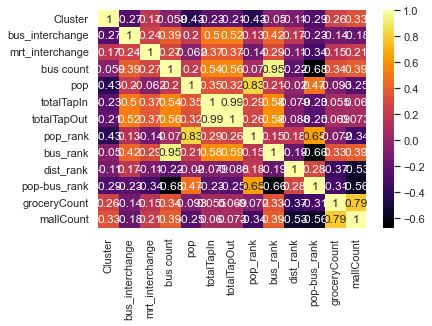

In [37]:
dataplot = sb.heatmap(
    combinedData[["Cluster", "bus_interchange", "mrt_interchange", "bus count", "pop", "totalTapIn", "totalTapOut", "pop_rank", "bus_rank", "dist_rank", "pop-bus_rank", "groceryCount", "mallCount"]].corr(),
    cmap="inferno", annot=True)

In [38]:
import seaborn as sns

<AxesSubplot:xlabel='groceryCount', ylabel='Cluster'>

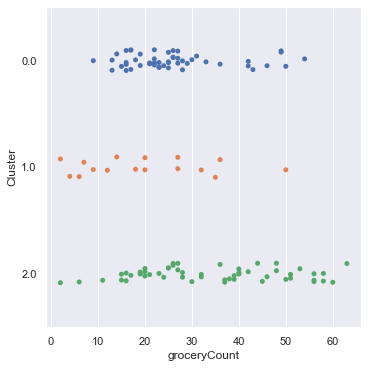

In [78]:
f, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

sns.stripplot(x = 'groceryCount', y = "Cluster", data = combinedData, orient = "h", ax = axes)

### Tetiary testing

In [112]:
combinedData["groceryCount"].fillna(0, inplace=True)
combinedData["mallCount"].fillna(0, inplace=True)
operational = combinedData[(combinedData["status"]!="future")
                           #& (combinedData["hub"].notna())
                          ]
y = operational["Cluster"]
X = pd.DataFrame(operational[[
                               "bus_interchange", "mrt_interchange", 
                               "pop", "totalTapIn", "totalTapOut", 
                                "groceryCount", "mallCount",
                               ]].to_numpy())

# Split the Dataset into random Train and Test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

logReg = LogisticRegression(multi_class= 'multinomial', solver = 'lbfgs', max_iter = 1000000)         # create the linear regression object
logReg.fit(X_train, y_train)        # train the linear regression model


# Predict Response corresponding to Predictors
y_train_pred = logReg.predict(X_train)
y_test_pred = logReg.predict(X_test)


############## TRAIN
y_train_NP = y_train.to_numpy()
resultsTrain = y_train_NP - y_train_pred
train_acc = np.count_nonzero(resultsTrain==0)/y_train_NP.size

print("Train Accuracy =", train_acc)

############## TEST
y_test_NP = y_test.to_numpy()
resultsTest = y_test_NP - y_test_pred
test_acc = np.count_nonzero(resultsTest==0)/y_test_NP.size

print("Test Accuracy =", test_acc)
 

# ############## OTHER STUFF
# cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=2, random_state=1)
# n_scores = cross_val_score(logReg, X_train, y_train, scoring='accuracy', cv = cv)
# print('Mean Accuracy[Train]: %.3f (%.3f)' % (mean(np.nan_to_num(n_scores)), std(np.nan_to_num(n_scores))))
# n_scores = cross_val_score(logReg, X_test, y_test, scoring='accuracy', cv = cv)
# print('Mean Accuracy[Test]: %.3f (%.3f)' % (mean(np.nan_to_num(n_scores)), std(np.nan_to_num(n_scores))))


# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# # Check the Goodness of Fit (on Train Data)
# n_scores = cross_val_score(logReg, X_train, y_train, scoring='accuracy', cv = cv)
# print('Mean Accuracy[Train]: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# print()/

# # Check the Goodness of Fit (on Test Data)
# n_scores = cross_val_score(logReg, X_test, y_test, scoring='accuracy', cv = cv)
# print('Mean Accuracy[Test]: %.3f (%.3f)' % (mean(n_scores), std(n_scoreaas)))
# print()

Train Accuracy = 0.6138613861386139
Test Accuracy = 0.5769230769230769


In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver = 'eigen', shrinkage = 'auto')
clf.fit(X_train, y_train)
# Predict Response corresponding to Predictors
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

y_train_NP = y_train.to_numpy()
resultsTrain = y_train_NP - y_train_pred
train_acc = np.count_nonzero(resultsTrain==0)/y_train_NP.size

print("Train Accuracy =", train_acc)

############## TEST
y_test_NP = y_test.to_numpy()
resultsTest = y_test_NP - y_test_pred
test_acc = np.count_nonzero(resultsTest==0)/y_test_NP.size

print("Test Accuracy =", test_acc)



Train Accuracy = 0.693069306930693
Test Accuracy = 0.7307692307692307


In [435]:
combinedData.to_csv("4clusterWithGrocery.csv")

# Mall Data Scraping

https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore

Exported as text file

In [55]:
with open('listOfMalls.txt') as f:
    contents = f.read()
contents = contents.splitlines()
for i in range(len(contents)):
    line = contents[i]
    if "[" in line:
        idx = line.find('[')
        contents[i] = line[:idx]
    
contents

['100 AM',
 '313@Somerset',
 'Aperia',
 'Balestier Hill Shopping Centre',
 'Bugis Cube',
 'Bugis Junction',
 'Bugis+',
 'Capitol Piazza',
 'Cathay Cineleisure Orchard',
 'Clarke Quay Central',
 'The Centrepoint',
 'City Square Mall',
 'City Gate Mall',
 'CityLink Mall',
 'Duo',
 'Far East Plaza',
 'Funan',
 'Great World City',
 'HDB Hub',
 'Holland Village Shopping Mall',
 'ION Orchard',
 'Junction 8',
 'Knightsbridge',
 'Liat Towers',
 'Lucky Plaza',
 'Marina Bay Sands',
 'The Shoppes at Marina Bay Sands',
 'Marina Bay Link Mall',
 'Marina Square',
 'Millenia Walk',
 'Mustafa Shopping Centre',
 'Ngee Ann City',
 'Orchard Central',
 'Orchard Gateway',
 'Orchard Plaza',
 'Midpoint Orchard',
 'Palais Renaissance',
 "People's Park Centre",
 "People's Park Complex",
 'Plaza Singapura',
 'PoMo',
 'Raffles City',
 'Scotts Square',
 'Shaw House and Centre',
 'Sim Lim Square',
 'Singapore Shopping Centre',
 'The South Beach',
 'Square 2',
 'Sunshine Plaza',
 'Suntec City',
 'Tanglin Mall',
 'T

In [22]:
def getcoordinates2(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal={'+address+'}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']
    else:
        pass

# http://commonapi/search?searchVal={313@Somerset}&returnGeom={Y/N}&getAddrDetails={Y/N}&pageNum={PageNumber}

In [56]:
coordinateslistMall= []
count = 0
failed_count = 0
for mall in contents:
    try:
        if len(getcoordinates2(mall))>0:
            count = count + 1
            #print('Extracting',count,'out of',len(contents),'addresses')
            coordinateslistMall.append(getcoordinates2(mall))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(contents),'addresses')
        coordinateslistMall.append((None,None))
print('Total Number of Addresses With No Coordinates',failed_count)

Failed to extract 10 out of 165 addresses
Failed to extract 13 out of 165 addresses
Failed to extract 20 out of 165 addresses
Failed to extract 31 out of 165 addresses
Failed to extract 41 out of 165 addresses
Failed to extract 44 out of 165 addresses
Failed to extract 65 out of 165 addresses
Failed to extract 73 out of 165 addresses
Failed to extract 81 out of 165 addresses
Failed to extract 83 out of 165 addresses
Failed to extract 157 out of 165 addresses
Total Number of Addresses With No Coordinates 11


In [96]:
latlngMall = np.array(coordinateslistMall, dtype=object, ndmin=2)

In [97]:
mallData = pd.DataFrame(latlngMall)
mallData.rename(columns={0: "lat", 1: "lng"}, inplace = True)
mallData["mallName"] = contents
mallData.head()

,lat,lng,mallName
0,1.27458821795426,103.84347073661,100 AM
1,1.30138510214714,103.837684350436,313@Somerset
2,1.30974242004976,103.864101650501,Aperia
3,1.3257612790349,103.843054082553,Balestier Hill Shopping Centre
4,1.29819500487878,103.855655544739,Bugis Cube


In [98]:
print(f"No of rows dropped: {mallData[mallData['lat'].isna()].shape[0]}")
print(f"Total number of rows: {mallData.shape[0]}")
print(f"Percent of data lost: {mallData[mallData['lat'].isna()].shape[0]*100/mallData.shape[0]}%")
mallData.dropna(subset=['lat','lng'], inplace = True)

No of rows dropped: 11
Total number of rows: 165
Percent of data lost: 6.666666666666667%


## Count of malls in Singapore

In [99]:
numberOfKM = 3

def toFloat(n):
    return float(n);

f = list(map(toFloat, mallData.lat))
g = list(map(toFloat, mallData.lng))
circleMall = gpd.GeoDataFrame([
    {'geometry': Point(x, y).buffer(0.008*numberOfKM)}
    for x, y in zip(f,g)])

#newdf = pointMRT.intersection(circleMarket)
newdfMall = mrt_gdf.overlay(circleMall, how="intersection")
# f = lambda x:np.sum(circleMarket.intersects(x))
# pointMRT.apply(f)

newdfMall.sort_values(by=['station_code'], inplace = True)

In [100]:
newdfGBM = newdfMall.groupby(["code"])
newdfGBM = newdfGBM.agg({'x': ['count']}).reset_index()
try:
    combinedData.drop(columns=["mallCount"], inplace =True)
except:
    pass
combinedData = pd.merge(combinedData, newdfGBM, on=['code'], how='left')

C:\Users\bryan\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\bryan\anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [101]:
combinedData[combinedData["status"]=="future"].describe()

,Unnamed: 0,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,totalTapIn,totalTapOut,Cluster,postal,x,y,lat,long,bus count,pop,groceryCount,"(x, count)"
count,24.000000,0.0,0.0,4.000000,0.0,1.0,0.0,0.0,2.000000,0.0,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,22.000000,24.000000,24.000000
mean,84.875000,NaN,NaN,27.750000,NaN,18.0,NaN,NaN,36.500000,NaN,21.611111,NaN,NaN,NaN,NaN,NaN,NaN,303547.625000,32854.271779,31782.080005,1.303700,103.876937,9.833333,8840.000000,27.458333,14.250000
std,35.332351,NaN,NaN,6.551081,NaN,NaN,NaN,NaN,0.707107,NaN,6.500126,NaN,NaN,NaN,NaN,NaN,NaN,206222.450673,5236.599933,3363.167382,0.030415,0.047054,11.044049,9495.168696,10.737902,11.283886
min,4.000000,NaN,NaN,18.000000,NaN,18.0,NaN,NaN,36.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,18928.000000,26402.802660,28030.479920,1.269772,103.818967,0.000000,20.000000,9.000000,2.000000
25%,88.750000,NaN,NaN,27.000000,NaN,18.0,NaN,NaN,36.250000,NaN,16.500000,NaN,NaN,NaN,NaN,NaN,NaN,96916.000000,28167.276110,29163.834133,1.280022,103.834822,1.750000,1100.000000,19.250000,5.750000
50%,100.500000,NaN,NaN,30.500000,NaN,18.0,NaN,NaN,36.500000,NaN,22.500000,NaN,NaN,NaN,NaN,NaN,NaN,299478.500000,31583.149220,31469.243035,1.300871,103.865514,7.000000,7450.000000,28.000000,9.500000
75%,106.250000,NaN,NaN,31.250000,NaN,18.0,NaN,NaN,36.750000,NaN,26.750000,NaN,NaN,NaN,NaN,NaN,NaN,449970.250000,36689.618862,32922.657170,1.314013,103.911401,13.000000,10362.500000,35.250000,20.750000
max,113.000000,NaN,NaN,32.000000,NaN,18.0,NaN,NaN,37.000000,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,828604.000000,42643.962380,44081.133460,1.414927,103.964903,44.000000,34490.000000,48.000000,40.000000


In [102]:
combinedData.rename(columns={('x', 'count'):"mallCount"}, inplace=True)
combinedData["mallCount"].fillna(0, inplace=True)

In [103]:
import seaborn as sns

<AxesSubplot:xlabel='bus count', ylabel='Cluster'>

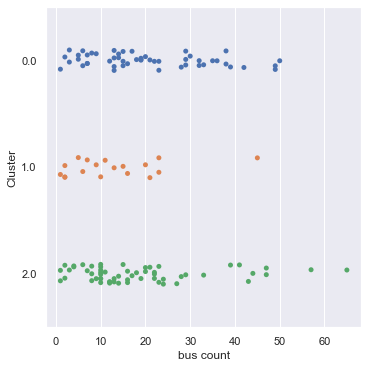

In [116]:
f, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

sns.stripplot(x = 'bus count', y = "Cluster", data = combinedData, orient = "h", ax = axes)

In [105]:
combinedData[combinedData["mallCount"]>20]

,Unnamed: 0,station_code,code,code2,code3,interchange,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,name,totalTapIn,totalTapOut,Cluster,postal,x,y,lat,long,subzone,area,region,status,bus_interchange,mrt_interchange,svc,bus count,pop,code1,geometry,groceryCount,mallCount
8,320,CC2,CC2,NaN,NaN,False,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bras Basah,49258.75,52827.75,2.0,189561,29930.76738,31025.90160,1.296862,103.850667,Bras Basah,Museum,Central,operational,False,False,"130,147,850E,124,147A,162M,7A,12,131,502,2A,13...",57,10.0,NaN,POINT (1.297 103.851),56.0,50.0
18,720,CC3,CC3,NaN,NaN,False,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Esplanade,76862.00,67622.00,2.0,189562,30421.99348,30671.62777,1.293658,103.855081,City Hall,Downtown Core,Central,operational,False,False,"130,850E,162M,107M,70,502,131,961M,196A,133,19...",44,80.0,NaN,POINT (1.294 103.855),50.0,42.0
19,760,CC4/DT15,CC4,DT15,NaN,True,NaN,NaN,4.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,Promenade,170624.25,179801.50,2.0,39193,31008.36188,30709.25781,1.293998,103.860350,Marina Centre,Downtown Core,Central,operational,True,True,"97,162M,107M,502,97e,133,111,868E,36,857,502A,...",19,10.0,NaN,POINT (1.294 103.860),40.0,35.0
20,800,CC5,CC5,NaN,NaN,False,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicoll Highway,52465.00,53374.50,2.0,38970,31374.16493,31347.15287,1.299767,103.863637,Nicoll,Downtown Core,Central,operational,False,False,"196,70A,70M,70,14A,10,16,196A,16M,14",10,290.0,NaN,POINT (1.300 103.864),42.0,28.0
24,960,CE1/DT16,CE1,DT16,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0,NaN,NaN,NaN,NaN,NaN,Bayfront,282228.00,289490.75,2.0,18957,30867.00927,29368.62503,1.281874,103.859080,Bayfront Subzone,Downtown Core,Central,operational,False,True,"NR6,502A,97,106,NR1,518,502,97e,518A,133",10,0.0,NaN,POINT (1.282 103.859),26.0,25.0
27,1080,DT10,DT10,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,Stevens,70168.00,57205.25,2.0,257877,27188.22996,33591.66086,1.320066,103.826024,Nassim,Tanglin,Central,operational,False,True,"170A,105,190,972A,NR3,960e,NR2,190A,48,960,132...",14,9520.0,NaN,POINT (1.320 103.826),30.0,22.0
28,1120,DT13,DT13,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,Rochor,111988.75,115462.50,2.0,188505,30164.70185,31798.87668,1.303852,103.852769,Bencoolen,Rochor,Central,operational,False,False,"170A,131A,56,851e,166,57,851,23,960e,131,48,96...",16,1310.0,NaN,POINT (1.304 103.853),56.0,49.0
29,1160,DT17,DT17,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,Downtown,135764.75,135289.00,1.0,18969,30172.66881,29100.20877,1.279446,103.852841,Central Subzone,Downtown Core,Central,operational,False,False,"130,186,672,97,670,653,850E,651,671,70,131,97e...",45,880.0,NaN,POINT (1.279 103.853),27.0,25.0
30,1200,DT18,DT18,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,Telok Ayer,132294.25,141547.50,1.0,48416,29706.12592,29390.19539,1.282069,103.848649,Chinatown,Outram,Central,operational,False,False,"130,186,850E,70,131,196,656,970,665,868E,162,6...",23,10490.0,NaN,POINT (1.282 103.849),36.0,34.0
32,1280,DT20,DT20,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,Fort Canning,59072.50,62220.75,2.0,179038,29225.62761,30541.60877,1.292482,103.844331,Clarke Quay,Singapore River,Central,operational,False,False,"NR6,5N,195,139,2N,1N,32,195A,NR5,6N,NR8,64,NR3...",20,130.0,NaN,POINT (1.292 103.844),58.0,48.0


In [66]:
combinedData.describe()

,Unnamed: 0,NS,SW,CC,EW,NE,BP,CE,DT,PW,TE,PE,CG,SE,totalTapIn,totalTapOut,Cluster,postal,x,y,lat,long,bus count,pop,groceryCount,mallCount
count,151.000000,27.000000,0.0,32.000000,33.00000,17.000000,2.000000,2.000000,36.000000,1.0,27.000000,1.0,2.000000,1.0,127.000000,127.000000,127.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,149.000000,150.000000,151.000000
mean,2259.953642,14.814815,NaN,16.500000,17.00000,9.941176,3.500000,1.500000,19.416667,0.0,16.074074,0.0,1.500000,0.0,253448.606299,253141.876640,1.055118,392746.589404,28726.678465,34872.608400,1.331649,103.839848,16.907285,15828.187919,28.686667,13.754967
std,1958.236231,8.208987,NaN,9.380832,9.66954,5.153525,3.535534,0.707107,10.672729,NaN,9.675210,NaN,0.707107,NaN,209288.243496,216656.428593,0.928449,233659.249588,7436.656635,5202.731095,0.047051,0.066823,13.715369,23017.560660,13.379909,13.573978
min,0.000000,1.000000,NaN,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,21891.000000,22013.000000,0.000000,18925.000000,6150.862788,27545.853430,1.265389,103.636991,0.000000,0.000000,2.000000,0.000000
25%,540.000000,8.500000,NaN,8.750000,9.00000,6.000000,2.250000,1.250000,10.750000,0.0,7.500000,0.0,1.250000,0.0,82850.833333,77788.875000,0.000000,189033.000000,24021.272255,31322.069460,1.299540,103.797568,7.000000,450.000000,19.000000,5.000000
50%,2040.000000,15.000000,NaN,16.500000,17.00000,10.000000,3.500000,1.500000,19.500000,0.0,16.000000,0.0,1.500000,0.0,186464.750000,179801.500000,1.000000,398006.000000,29473.124940,33698.726310,1.321027,103.846555,14.000000,7450.000000,26.000000,8.000000
75%,3540.000000,21.500000,NaN,24.250000,25.00000,14.000000,4.750000,1.750000,28.250000,0.0,24.500000,0.0,1.750000,0.0,397368.250000,370259.875000,2.000000,576917.500000,33345.748700,36582.363990,1.347111,103.881353,23.000000,26880.000000,37.750000,18.000000
max,10512.000000,28.000000,NaN,32.000000,33.00000,18.000000,6.000000,2.000000,37.000000,0.0,31.000000,0.0,2.000000,0.0,985138.250000,998749.500000,2.000000,828868.000000,45201.320390,47854.199840,1.449051,103.987884,65.000000,130980.000000,63.000000,50.000000


In [107]:
combinedData.to_csv("dataCombined_3Clusters_Ammenities.csv")